# Sheet Recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from img_data.mapping import SHEET_CLASSES
from sheets import SheetRecognition

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

In [2]:
sheet_recg = SheetRecognition("img_data/data")

In [3]:
X, Y = sheet_recg.build_dataset()

In [4]:
df = sheet_recg.get_info()
df.head()

,major_axis,minor_axis,width,height,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu_moment_1,hu_moment_2,hu_moment_3,hu_moment_4,hu_moment_5,hu_moment_6,hu_moment_7,class_label,class_name
0,219.596802,178.559341,178.0,219.0,15926.0,1182.714844,0.812785,0.143073,2.447695,6.644465,0.000821,4.088961e-08,4.356074e-11,2.586440e-11,8.673062e-22,4.284754e-15,-3.855395e-23,0,Acer_Palmatum
1,258.701172,225.256409,227.0,255.0,21674.5,1353.266113,0.890196,0.148728,2.670650,5.961525,0.000787,1.117762e-08,4.071149e-11,1.023093e-11,2.025039e-22,1.027020e-15,5.088968e-23,0,Acer_Palmatum
2,273.048340,225.901520,232.0,270.0,23012.5,1463.775757,0.859259,0.134966,2.721999,6.309379,0.000805,2.126200e-08,3.687593e-11,1.564790e-11,3.743818e-22,2.230185e-15,-3.359029e-23,0,Acer_Palmatum
3,262.246185,229.644562,230.0,264.0,26428.0,1421.248901,0.871212,0.164412,2.297563,6.179343,0.000763,7.215971e-09,2.856711e-11,1.562313e-12,2.957098e-24,9.543125e-17,1.000956e-23,0,Acer_Palmatum
4,267.917877,207.458084,213.0,257.0,19800.5,1340.864136,0.828794,0.138394,2.764627,6.295137,0.000806,1.524819e-08,2.991710e-11,1.280422e-11,2.498123e-22,1.446480e-15,1.991376e-23,0,Acer_Palmatum


In [5]:
print(df['class_label'].unique())
print(df['class_name'].unique())

[0 1 2 3 4 5 6]
['Acer_Palmatum' 'Cedrus_Deodara' 'Cercis_Chinensis'
 'Citrus_Reticulata_Blanco' 'Ginkgo_Biloba' 'Liriodendron_Chinense'
 'Nerium_Oleander']


In [6]:
X.shape, Y.shape

((442, 17), (442,))

In [ ]:
def train_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {}
    
    # SVM
    #print("Training SVM")
    svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
    svm.fit(X_train_scaled, y_train)
    models['SVM'] = svm
    
    # KNN
    #print("Training KNN")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    models['KNN'] = knn
    
    # MLP
    #print("Training MLP")
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32), 
        max_iter=1000, 
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20
    )
    mlp.fit(X_train_scaled, y_train)
    models['MLP'] = mlp

    #results
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_proba,
            'test_features': X_test_scaled,
            'test_labels': y_test
        }
        print(f"{name} accuracy: {accuracy:.4f}")

    return results, models, scaler, X_train_scaled, y_train, X_test_scaled, y_test

In [8]:
results, models, scaler, X_train_scaled, y_train, X_test_scaled, y_test = train_models(X, Y)

SVM accuracy: 1.0000
KNN accuracy: 1.0000
MLP accuracy: 0.9551


In [28]:
def plot_confusion_matrix(results, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Confusion Matrix Comparison - Leaf Classification Models', y=1.02)
    
    models = list(results.keys())
    
    for idx, model_name in enumerate(models):
        ax = axes[idx]
        model_results = results[model_name]
        
        y_true = model_results['test_labels']
        y_pred = model_results['predictions']
        
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        im = ax.imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
        
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
                ax.text(j, i, f'{cm_normalized[i, j]:.2f}\n({cm[i, j]})', ha='center', va='center', color=text_color)
        
        ax.set_title(f'{model_name}\nAccuracy: {model_results["accuracy"]:.3f}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names)
        
        #gid
        ax.set_xticks(np.arange(-0.5, len(class_names)), minor=True)
        ax.set_yticks(np.arange(-0.5, len(class_names)), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.2, alpha = 0.8)
        ax.tick_params(which='minor', bottom=False, left=False)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training(results, X_train, y_train, class_names):
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle('Model Training Characteristics and Performance Analysis', y=0.98)
    
    gs = fig.add_gridspec(3, 3)
    
    #class distribution
    ax1 = fig.add_subplot(gs[0, 0])
    unique, counts = np.unique(y_train, return_counts=True)
    bars = ax1.bar(range(len(unique)), counts, color=plt.cm.Set3(np.linspace(0, 1, len(unique))))
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Class Label')
    ax1.set_ylabel('Number of Samples')
    ax1.set_xticks(range(len(unique)))
    ax1.set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')
    
    #time Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    inference_times = {}
    
    for model_name, model_results in results.items():
        model = model_results['model']
        X_test = model_results['test_features']
        
        #calculating time
        start_time = time.time()
        _ = model.predict(X_test[:20]) 
        inference_time = time.time() - start_time
        inference_times[model_name] = inference_time
    
    models = list(inference_times.keys())
    times = list(inference_times.values())
    
    bars = ax2.bar(models, times, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    ax2.set_title('Inference Time Comparison')
    ax2.set_ylabel('Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)
    
    #bar
    ax3 = fig.add_subplot(gs[0, 2])
    
    metrics_data = []
    for model_name, model_results in results.items():
        y_test = model_results['test_labels']
        y_pred = model_results['predictions']
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        metrics_data.append({
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': model_results['accuracy']
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    x = np.arange(len(metrics_df))
    width = 0.2
    
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    colors_metrics = ['#FF9999', '#99FF99', '#9999FF', '#FFFF99']
    
    for i, metric in enumerate(metrics_to_plot):
        ax3.bar(x + i*width, metrics_df[metric], width, label=metric, 
               color=colors_metrics[i], alpha=0.8)
    
    ax3.set_title('Comprehensive Model Metrics')
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Score')
    ax3.grid(axis='y', alpha=0.3)
    
    #models Accuracy comparison
    ax4 = fig.add_subplot(gs[1, 1])
    accuracies = [results[name]['accuracy'] for name in models]
    
    bars = ax4.bar(models, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],)
    ax4.set_title('Model Accuracy Comparison')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim(0, 1)
    ax4.grid(axis='y', alpha=0.3)
    
    #Table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.set_title('Summary Table')
    ax5.axis('off')
    
    #data
    table_data = []
    for model_name, model_results in results.items():
        y_test = model_results['test_labels']
        y_pred = model_results['predictions']
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        table_data.append([
            model_name,
            f"{model_results['accuracy']:.3f}",
            f"{precision:.3f}",
            f"{recall:.3f}",
            f"{f1:.3f}",
            f"{inference_times[model_name]:.4f}s",
            f"{len(y_test)}"
        ])
    
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Inference Time', 'Test Samples']
    table = ax5.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.5)
    
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#365E7D')
        table[(0, i)].set_text_props(color='white')
    
    best_model_idx = accuracies.index(max(accuracies))
    for i in range(len(columns)):
        table[(best_model_idx + 1, i)].set_facecolor('#E8F4FD')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_f1_Score(results, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('F1-Score Performance')
    
    models = list(results.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    x_pos = np.arange(len(class_names))
    width = 0.25
    
    for idx, (model_name, color) in enumerate(zip(models, colors)):
        ax = axes[idx]
        model_results = results[model_name]
        
        y_test = model_results['test_labels']
        y_pred = model_results['predictions']
        
        _, _, f1_scores, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
        
        bars = ax.bar(x_pos + idx*width, f1_scores, width, label=model_name, color=color, alpha=0.8)
        
        ax.set_title(f'{model_name} - Class Performance')
        ax.set_xlabel('Classes')
        ax.set_ylabel('F1-Score')
        ax.set_xticks(x_pos + width)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

## Results

In [ ]:
class_names = list(SHEET_CLASSES.keys())

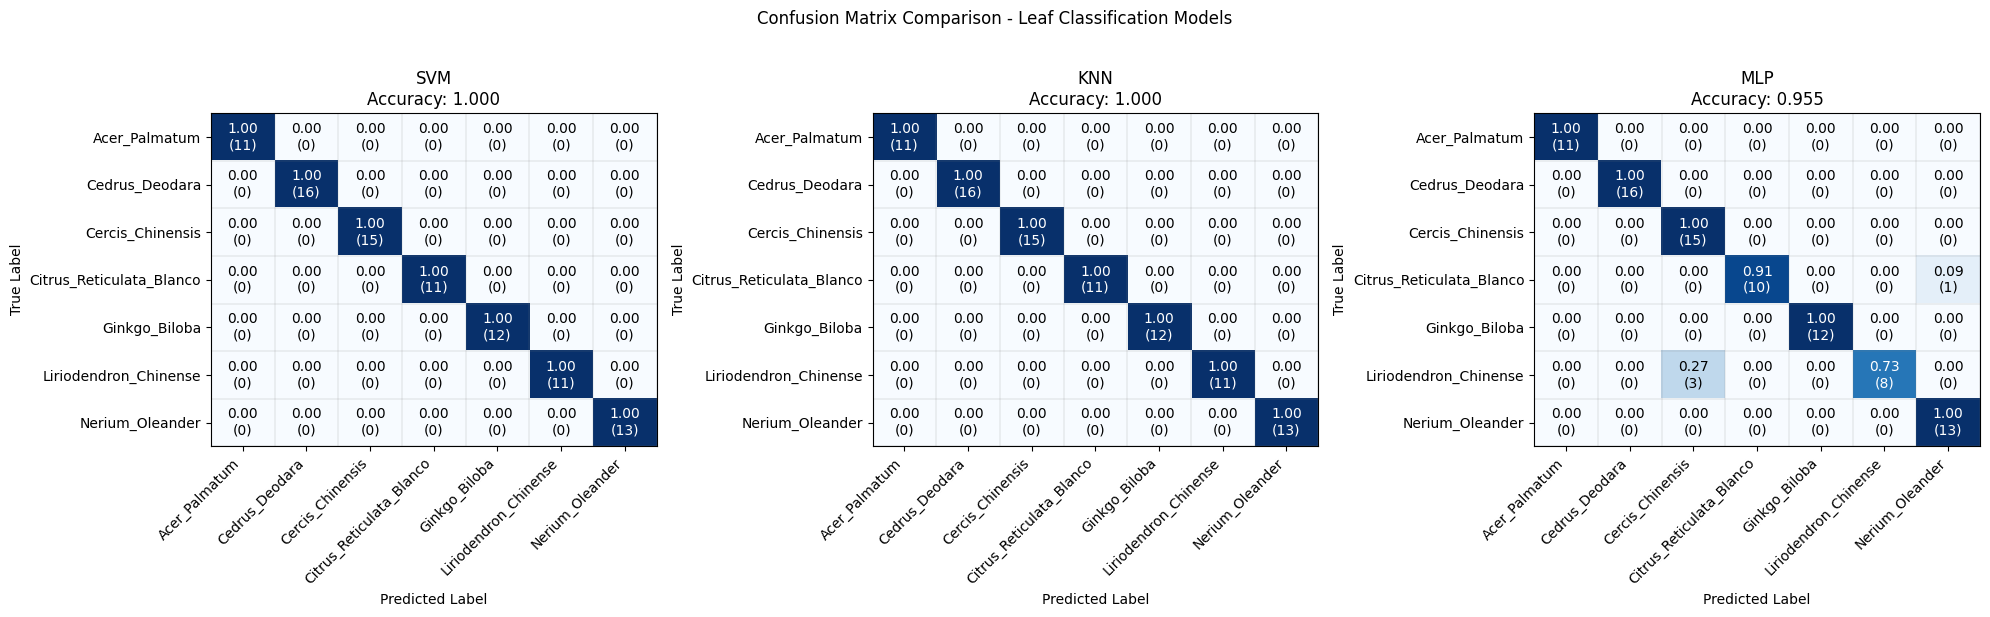

In [ ]:
plot_confusion_matrix(results, class_names)

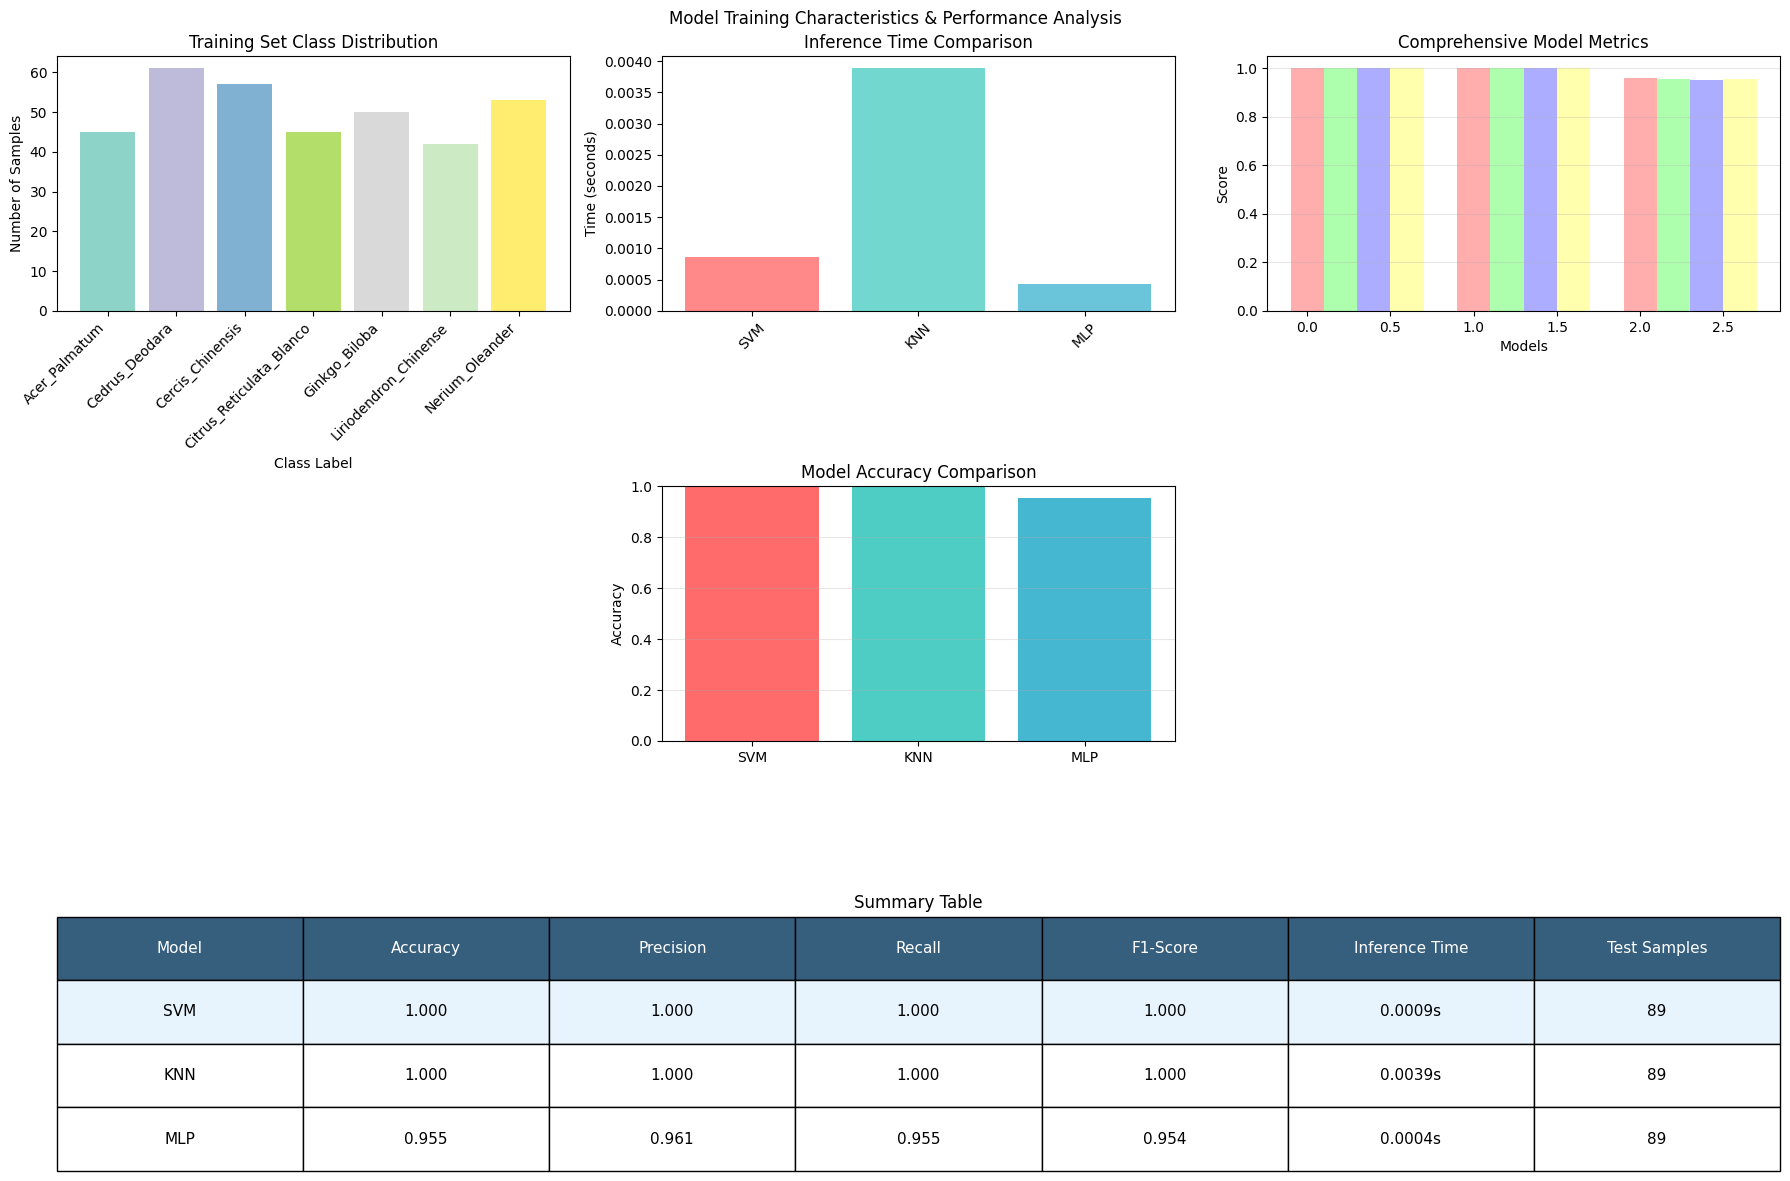

In [ ]:
plot_training(results, X_train_scaled, y_train, class_names)

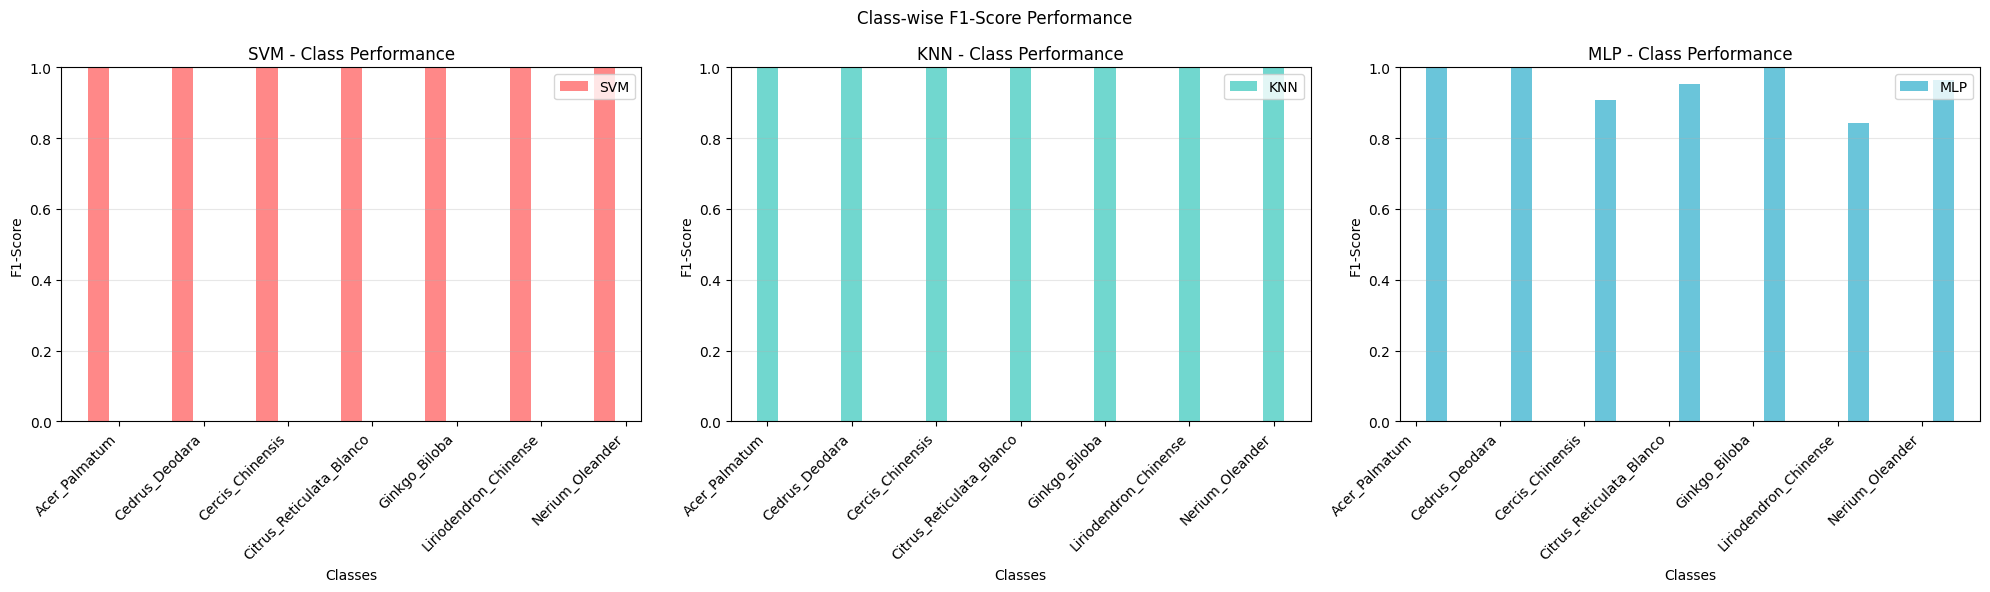

In [ ]:
plot_f1_Score(results, class_names)